# DS2. 泰坦尼克号案例 (Kaggle, Titanic Project Example)

> - 本案例的数据库来自 Kaggle 的竞赛 [Titanic - Machine Learning from Disaster](https://www.kaggle.com/c/titanic)
> - 教程代码来自 [Ken Jee, Titanic Project Example](https://www.kaggle.com/code/kenjee/titanic-project-example/notebook)
> - 视频教学 [Youtube | Beginner Kaggle Data Science Project Walk-Through (Titanic)](https://www.youtube.com/watch?v=I3FBJdiExcg&ab_channel=KenJee)
> - 本文的主要目的再与提供一个入门数据科学的教程，并不会纠结于算法。

在这个笔记本中，我希望展示数据科学家如何解决问题。 目标是正确预测一个人是否在泰坦尼克号海难中幸存下来。 本文的不涉及深度学习算法，不过在以后的案例中会慢慢介绍深度学习方法。

![](./pics/blue.png)

## 1. 概述

1. 使用各类可视化方法比如：直方图、箱线图等，了解数据的形状。(Vuslization)
2. 数据清洗 (Data Cleaning)
3. 数据探索 (Data Exploration)
4. 特征工程 (Feature Engineering)
5. 模型数据预处理 (Data Preprocessing for Model)
6. 构建基本模型 (Basic Model Building)
7. 模型调整 (Model Tuning)
8. 整合模型 (Ensemble Modle Building)
9. 结果 (Results)

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns 
import matplotlib.pyplot as plt

导入数据集 `training` 和 `test`，并且我们会为数据集添加 `train_test` 这一列用于记录模型的输出。此外由于我们并不知道测试集中的人是否存活，因此我们先设置 `test['Survived']` 这一列为 `np.NaN`，即无。

In [2]:
training = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')

training['train_test'] = 1
test['train_test'] = 0
test['Survived'] = np.NaN
all_data = pd.concat([training,test])

%matplotlib inline
all_data.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'train_test'],
      dtype='object')

由于数据集中的很多列名称都是缩写，因此官方给出了下面的类别表格：

![类别表格](./pics/Dictionary.png)

![](./pics/green.png)

## 2. 项目规划

在开始任何项目时，我喜欢概述我计划采取的步骤，对于这个项目来说，我会做以下的一些事情。

- 使用 `.info()` 和 `.describe()` 来探索数据集。
- 使用直方图和箱体图将数据可视化。
- 记录各种值的次数。
- 找到空白值。
- 找到数据集中列与列的关系。
- 然后深入探索一些我比较感兴趣的主题，比如：
  - 有钱人的存活率
  - 位置
  - 年龄散点图与票价
  - 年轻而且有钱的人存活率
  - 总花费
- 特征工程。
- 预处理数据。
- 创建基础模型。
- 与参考答案的模型比较。

![](./pics/green.png)

## 3. 探索数据集

- 数字型数据
  - 画出直方图了解数据的分布
  - 画图相关性图
  - 比较数值变量存活率的数据透视表
- 类别型数据
  - 制作条形图以了解类别的平衡
  - 制作数据透视表以了解与生存的关系

In [5]:
#quick look at our data types & null counts 
training.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


从 `.info()` 中可以了解到数据集里是有一些空白数据的。

In [6]:
# to better understand the numeric data, 
# we want to use the .describe() method. 
# This gives us an understanding of the central tendencies of the data 
training.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


从这里我们可以了解到数值型数据的一些特征，比如我们比较关心的存活情况，在 891 个样本中，大约有 38% 的人幸存下来了。

In [7]:
#quick way to separate numeric columns
training.describe().columns

Index(['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare'], dtype='object')

接下来我们将数字型的数据与类别型的数据分开。

In [8]:
# look at numeric and categorical values separately 
df_num = training[['Age','SibSp','Parch','Fare']]
df_cat = training[['Survived','Pclass','Sex','Ticket','Cabin','Embarked']]

然后用直方图的形式了解数字型数据的分布。

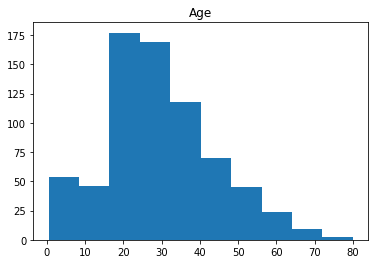

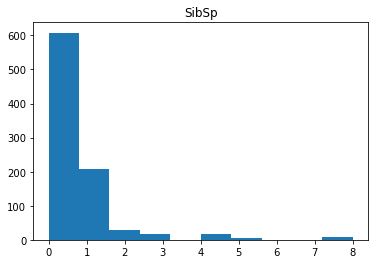

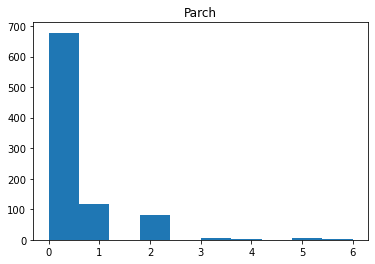

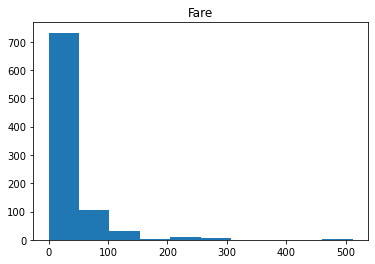

In [9]:
#distributions for all numeric variables 
for feature in df_num.columns:
    plt.hist(df_num[feature])
    plt.title(feature)
    plt.show()

目前来看，只有年龄属于高斯分布，其他的没有明显的分布特征。

接下来查看各列之间的是否存在正相关。

            Age     SibSp     Parch      Fare
Age    1.000000 -0.308247 -0.189119  0.096067
SibSp -0.308247  1.000000  0.414838  0.159651
Parch -0.189119  0.414838  1.000000  0.216225
Fare   0.096067  0.159651  0.216225  1.000000


<AxesSubplot:>

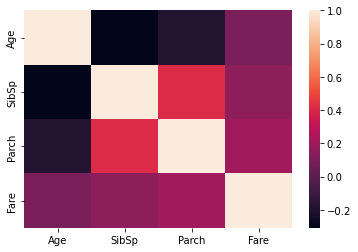

In [10]:
print(df_num.corr())
sns.heatmap(df_num.corr())

上图我们可以看出，家庭旅客与票价之间有较强的正相关。

接下来查看我们来查看一下各项数字信息与存活情况之间的关系：

In [11]:
pd.pivot_table(training, index = 'Survived', values = ['Age','SibSp','Parch','Fare'])

,Age,Fare,Parch,SibSp
Survived,,,,
0,30.626179,22.117887,0.329690,0.553734
1,28.343690,48.395408,0.464912,0.473684


我们可以看到，幸存者的平均年龄为 28.3 岁，票价平均为 48.4，有小孩或家长有数量为 0.46，有兄弟姐妹的数量为 0.47。而没有幸存的人，年龄会稍微大一点 30.63 岁，票价比较低 22.1，往往不是家庭旅客，但兄弟姐妹比较多 0.55.

接下来，我们来查看非数字类型的数据。首先用直方图来统计一下每一个非数字类型的数据其中的类别计数情况：

C:\Softwares\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


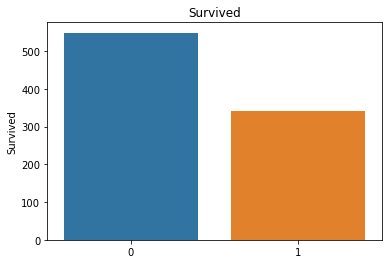

C:\Softwares\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


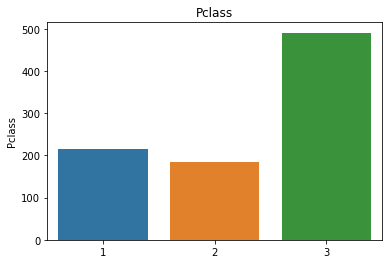

C:\Softwares\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


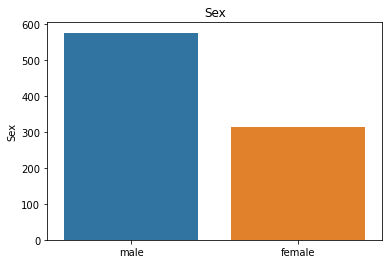

C:\Softwares\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


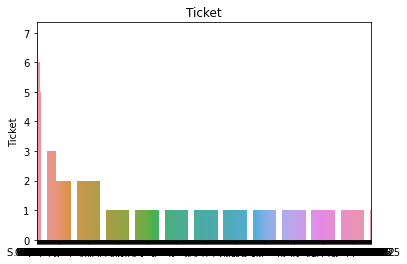

C:\Softwares\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


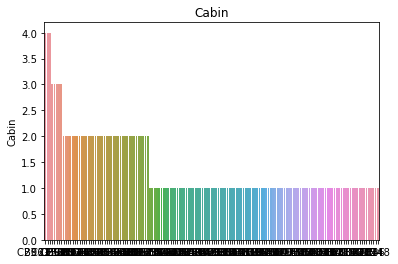

C:\Softwares\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


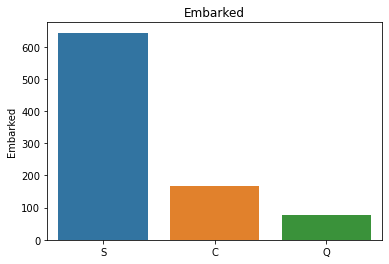

In [14]:
for i in df_cat.columns:
    sns.barplot(df_cat[i].value_counts().index, df_cat[i].value_counts()).set_title(i)
    plt.show()

大多数的信息还是比较直观的，但客舱和票务图表非常混乱。这是我们可能想做一些特征工程的领域！

然后我们来查看一下我们比较关系的幸存问题与这些列之间的关系。

In [15]:
# Comparing survival and each of these categorical variables 
print(pd.pivot_table(training, index = 'Survived', columns = 'Pclass', values = 'Ticket' ,aggfunc ='count'))
print()
print(pd.pivot_table(training, index = 'Survived', columns = 'Sex', values = 'Ticket' ,aggfunc ='count'))
print()
print(pd.pivot_table(training, index = 'Survived', columns = 'Embarked', values = 'Ticket' ,aggfunc ='count'))

Pclass      1   2    3
Survived              
0          80  97  372
1         136  87  119

Sex       female  male
Survived              
0             81   468
1            233   109

Embarked   C   Q    S
Survived             
0         75  47  427
1         93  30  217


从这可以看出，一等仓的人幸存的比较多，男性幸存的比较多，从 Southampton 登船的人幸存的比较多。

![](./pics/green.png)

## 3. 特征工程

> 针对之间比较模糊的票务和客舱，以及一个我们之前没有查看的人名信息，其中包含了一个人的头衔，比如 Mr, Miss, Dr, Sir, etc

- 客舱 - 简化客舱（评估客舱信 (cabin_adv) 或跨多个客舱 (cabin_multiple) 购买船票是否影响生存）
- 船票 - 不同的船票类型会影响生存率吗？
- 一个人的头衔与生存率有关吗？

首先我们来查看一下船舱信息

In [27]:
df_cat.Cabin

0       NaN
1       C85
2       NaN
3      C123
4       NaN
       ... 
886     NaN
887     B42
888     NaN
889    C148
890     NaN
Name: Cabin, Length: 891, dtype: object

下面我们按照字母来给此列分类

In [29]:
training['cabin_adv'] = training.Cabin.apply(lambda x: str(x)[0])

In [30]:
#comparing surivial rate by cabin
print(training.cabin_adv.value_counts())
pd.pivot_table(training,index='Survived',columns='cabin_adv', values = 'Name', aggfunc='count')

n    687
C     59
B     47
D     33
E     32
A     15
F     13
G      4
T      1
Name: cabin_adv, dtype: int64


cabin_adv,A,B,C,D,E,F,G,T,n
Survived,,,,,,,,,
0,8.0,12.0,24.0,8.0,8.0,5.0,2.0,1.0,481.0
1,7.0,35.0,35.0,25.0,24.0,8.0,2.0,NaN,206.0


接下来是船票列，我们分别按照数字和字母对票进行分类：

In [31]:
#understand ticket values better 
#numeric vs non numeric 
training['numeric_ticket'] = training.Ticket.apply(lambda x: 1 if x.isnumeric() else 0)
training['ticket_letters'] = training.Ticket.apply(lambda x: ''.join(x.split(' ')[:-1]).replace('.','').replace('/','').lower() if len(x.split(' ')[:-1]) >0 else 0)

In [32]:
training['numeric_ticket'].value_counts()

1    661
0    230
Name: numeric_ticket, dtype: int64

其中字母类型的船票有 230 张，数字类型的船票有 661 张。

In [33]:
#lets us view all rows in dataframe through scrolling. This is for convenience 
pd.set_option("max_rows", None)
training['ticket_letters'].value_counts()

0            665
pc            60
ca            41
a5            21
stono2        18
sotonoq       15
scparis       11
wc            10
a4             7
soc            6
fcc            5
c              5
sopp           3
pp             3
wep            3
ppp            2
scah           2
sotono2        2
swpp           2
fc             1
scahbasle      1
as             1
sp             1
sc             1
scow           1
fa             1
sop            1
sca4           1
casoton        1
Name: ticket_letters, dtype: int64

根据上面的对比，我们发现使用数字和非数字来分类更加便捷，然后我们再查看此列与幸存之间的关系：

In [34]:
#difference in numeric vs non-numeric tickets in survival rate 
pd.pivot_table(training,index='Survived',columns='numeric_ticket', values = 'Ticket', aggfunc='count')

numeric_ticket,0,1
Survived,,
0,142,407
1,88,254


最后我们对称呼进行特征工程处理。我们为表格添加一个新的列 `name_title`

In [35]:
#feature engineering on person's title 
training.Name.head(50)
training['name_title'] = training.Name.apply(lambda x: x.split(',')[1].split('.')[0].strip())
#mr., ms., master. etc

In [36]:
training['name_title'].value_counts()

Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Mlle              2
Major             2
Col               2
the Countess      1
Capt              1
Ms                1
Sir               1
Lady              1
Mme               1
Don               1
Jonkheer          1
Name: name_title, dtype: int64

![](./pics/green.png)

## 4. 模型数据预处理

- 从 Embarked 中删除空值（仅 2 个）
- 仅包括相关变量（由于我们的数据有限，我想排除姓名和乘客 ID 等内容，以便我们可以为模型处理合理数量的特征）
  - 现在我们还有这些特征： 'Pclass', 'Sex','Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'cabin_adv', 'cabin_multiple', 'numeric_ticket', 'name_title'
- 对所有数据进行分类转换。 通常我们会使用转换器，但通过这种方法，我们可以确保我们的训练和测试数据具有相同的列。 我们也可以通过这种方法推断出测试数据的形状。 我会强调，这通常不推荐在比赛之外（使用 onehot 编码器）。
- 用票价和年龄的平均值估算数据（也应该用中位数进行试验）。
- 使用对数归一化票价以提供更多的正态分布相似性。
- 使用标准缩放器缩放数据到 0-1 范围。

> 具体操作请看代码

(889,)

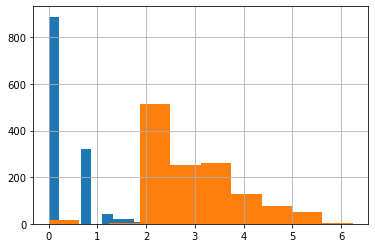

In [37]:
#create all categorical variables that we did above for both training and test sets 
all_data['cabin_multiple'] = all_data.Cabin.apply(lambda x: 0 if pd.isna(x) else len(x.split(' ')))
all_data['cabin_adv'] = all_data.Cabin.apply(lambda x: str(x)[0])
all_data['numeric_ticket'] = all_data.Ticket.apply(lambda x: 1 if x.isnumeric() else 0)
all_data['ticket_letters'] = all_data.Ticket.apply(lambda x: ''.join(x.split(' ')[:-1]).replace('.','').replace('/','').lower() if len(x.split(' ')[:-1]) >0 else 0)
all_data['name_title'] = all_data.Name.apply(lambda x: x.split(',')[1].split('.')[0].strip())

#impute nulls for continuous data 
#all_data.Age = all_data.Age.fillna(training.Age.mean())
all_data.Age = all_data.Age.fillna(training.Age.median())
#all_data.Fare = all_data.Fare.fillna(training.Fare.mean())
all_data.Fare = all_data.Fare.fillna(training.Fare.median())

#drop null 'embarked' rows. Only 2 instances of this in training and 0 in test 
all_data.dropna(subset=['Embarked'],inplace = True)

#tried log norm of sibsp (not used)
all_data['norm_sibsp'] = np.log(all_data.SibSp+1)
all_data['norm_sibsp'].hist()

# log norm of fare (used)
all_data['norm_fare'] = np.log(all_data.Fare+1)
all_data['norm_fare'].hist()

# converted fare to category for pd.get_dummies()
all_data.Pclass = all_data.Pclass.astype(str)

#created dummy variables from categories (also can use OneHotEncoder)
all_dummies = pd.get_dummies(all_data[['Pclass','Sex','Age','SibSp','Parch','norm_fare','Embarked','cabin_adv','cabin_multiple','numeric_ticket','name_title','train_test']])

#Split to train test again
X_train = all_dummies[all_dummies.train_test == 1].drop(['train_test'], axis =1)
X_test = all_dummies[all_dummies.train_test == 0].drop(['train_test'], axis =1)


y_train = all_data[all_data.train_test==1].Survived
y_train.shape

In [38]:
# Scale data 
from sklearn.preprocessing import StandardScaler
scale = StandardScaler()
all_dummies_scaled = all_dummies.copy()
all_dummies_scaled[['Age','SibSp','Parch','norm_fare']]= scale.fit_transform(all_dummies_scaled[['Age','SibSp','Parch','norm_fare']])
all_dummies_scaled

X_train_scaled = all_dummies_scaled[all_dummies_scaled.train_test == 1].drop(['train_test'], axis =1)
X_test_scaled = all_dummies_scaled[all_dummies_scaled.train_test == 0].drop(['train_test'], axis =1)

y_train = all_data[all_data.train_test==1].Survived

![](./pics/green.png)

## 5. 构建基本模型

这里我们使用 5-fold 交叉验证的方式对下面的几种基本算法进行了评比。使用验证集基准，我们可以看到调整对每个模型的改进程度。 仅仅因为模型在此验证集上具有较高的基线并不意味着它实际上会在最终的测试集上做得更好。

- Naive Bayes (72.6%)
- Logistic Regression (82.1%)
- Decision Tree (77.6%)
- K Nearest Neighbor (80.5%)
- Random Forest (80.6%)
- Support Vector Classifier (83.2%)
- Xtreme Gradient Boosting (81.8%)
- Soft Voting Classifier - All Models (82.8%)

In [39]:
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [40]:
#I usually use Naive Bayes as a baseline for my classification tasks 
gnb = GaussianNB()
cv = cross_val_score(gnb,X_train_scaled,y_train,cv=5)
print(cv)
print(cv.mean())

[0.66853933 0.70224719 0.75842697 0.74719101 0.73446328]
0.7221735542436362


In [41]:
lr = LogisticRegression(max_iter = 2000)
cv = cross_val_score(lr,X_train,y_train,cv=5)
print(cv)
print(cv.mean())

[0.8258427  0.80898876 0.80337079 0.82022472 0.85310734]
0.8223068621849807


In [42]:
lr = LogisticRegression(max_iter = 2000)
cv = cross_val_score(lr,X_train_scaled,y_train,cv=5)
print(cv)
print(cv.mean())

[0.8258427  0.80898876 0.80337079 0.82022472 0.85310734]
0.8223068621849807


In [43]:
dt = tree.DecisionTreeClassifier(random_state = 1)
cv = cross_val_score(dt,X_train,y_train,cv=5)
print(cv)
print(cv.mean())

[0.75842697 0.74719101 0.8258427  0.74719101 0.8079096 ]
0.7773122579826065


In [44]:
dt = tree.DecisionTreeClassifier(random_state = 1)
cv = cross_val_score(dt,X_train_scaled,y_train,cv=5)
print(cv)
print(cv.mean())

[0.75842697 0.74719101 0.8258427  0.74719101 0.8079096 ]
0.7773122579826065


In [45]:
knn = KNeighborsClassifier()
cv = cross_val_score(knn,X_train,y_train,cv=5)
print(cv)
print(cv.mean())

[0.76966292 0.80337079 0.80898876 0.82022472 0.85310734]
0.8110709071288008


In [46]:
knn = KNeighborsClassifier()
cv = cross_val_score(knn,X_train_scaled,y_train,cv=5)
print(cv)
print(cv.mean())

[0.79775281 0.79213483 0.83146067 0.79775281 0.85310734]
0.8144416936456548


In [47]:
rf = RandomForestClassifier(random_state = 1)
cv = cross_val_score(rf,X_train,y_train,cv=5)
print(cv)
print(cv.mean())

[0.80898876 0.79213483 0.84831461 0.73595506 0.82485876]
0.8020504030978227


In [48]:
rf = RandomForestClassifier(random_state = 1)
cv = cross_val_score(rf,X_train_scaled,y_train,cv=5)
print(cv)
print(cv.mean())

[0.80337079 0.79213483 0.84831461 0.73595506 0.82485876]
0.8009268075922046


In [49]:
svc = SVC(probability = True)
cv = cross_val_score(svc,X_train_scaled,y_train,cv=5)
print(cv)
print(cv.mean())

[0.85393258 0.82022472 0.8258427  0.80337079 0.86440678]
0.8335555132355742


In [54]:
from xgboost import XGBClassifier
xgb = XGBClassifier(random_state =1)
cv = cross_val_score(xgb,X_train_scaled,y_train,cv=5)
print(cv)
print(cv.mean())

C:\Softwares\Anaconda\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:38:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Softwares\Anaconda\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Softwares\Anaconda\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:38:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:38:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Softwares\Anaconda\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Softwares\Anaconda\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:38:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:38:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0.82022472 0.81460674 0.85393258 0.79775281 0.81355932]
0.8200152351932963


In [55]:
from sklearn.ensemble import VotingClassifier
voting_clf = VotingClassifier(estimators = [('lr',lr),('knn',knn),('rf',rf),('gnb',gnb),('svc',svc),('xgb',xgb)], voting = 'soft') 

In [56]:
cv = cross_val_score(voting_clf,X_train_scaled,y_train,cv=5)
print(cv)
print(cv.mean())

C:\Softwares\Anaconda\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:38:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Softwares\Anaconda\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:38:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Softwares\Anaconda\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:38:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Softwares\Anaconda\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:38:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Softwares\Anaconda\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:38:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0.83707865 0.81460674 0.8258427  0.79775281 0.84745763]
0.8245477051990097


In [57]:
voting_clf.fit(X_train_scaled,y_train)
y_hat_base_vc = voting_clf.predict(X_test_scaled).astype(int)
basic_submission = {'PassengerId': test.PassengerId, 'Survived': y_hat_base_vc}
base_submission = pd.DataFrame(data=basic_submission)
base_submission.to_csv('base_submission.csv', index=False)

C:\Softwares\Anaconda\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:38:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


![](./pics/green.png)

## 6. 优化模型

得到 baseline 后，看看能不能对个别模型的结果进行改进。我主要是用grid search来调优模型。我还使用随机森林的随机搜索和 XG 增强模型来简化测试时间。

|Model	|Baseline	|Tuned Performance|
|-------|--------|---------|
|Naive Bayes|	72.6%|	NA|
|Logistic Regression|	82.1%|	82.6%|
|Decision Tree|	77.6%	|NA|
|K Nearest Neighbor|	80.5%	|83.0%|
|Random Forest	|80.6%|	83.6%|
|Support Vector Classifier|	83.2%	|83.2%|
|Xtreme Gradient Boosting|	81.8%	|85.3%|

In [58]:
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import RandomizedSearchCV 

In [59]:
#simple performance reporting function
def clf_performance(classifier, model_name):
    print(model_name)
    print('Best Score: ' + str(classifier.best_score_))
    print('Best Parameters: ' + str(classifier.best_params_))

In [60]:
lr = LogisticRegression()
param_grid = {'max_iter' : [2000],
              'penalty' : ['l1', 'l2'],
              'C' : np.logspace(-4, 4, 20),
              'solver' : ['liblinear']}

clf_lr = GridSearchCV(lr, param_grid = param_grid, cv = 5, verbose = True, n_jobs = -1)
best_clf_lr = clf_lr.fit(X_train_scaled,y_train)
clf_performance(best_clf_lr,'Logistic Regression')

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Logistic Regression
Best Score: 0.8279375357074843
Best Parameters: {'C': 1.623776739188721, 'max_iter': 2000, 'penalty': 'l1', 'solver': 'liblinear'}


In [61]:
knn = KNeighborsClassifier()
param_grid = {'n_neighbors' : [3,5,7,9],
              'weights' : ['uniform', 'distance'],
              'algorithm' : ['auto', 'ball_tree','kd_tree'],
              'p' : [1,2]}
clf_knn = GridSearchCV(knn, param_grid = param_grid, cv = 5, verbose = True, n_jobs = -1)
best_clf_knn = clf_knn.fit(X_train_scaled,y_train)
clf_performance(best_clf_knn,'KNN')

Fitting 5 folds for each of 48 candidates, totalling 240 fits
KNN
Best Score: 0.8279375357074843
Best Parameters: {'algorithm': 'auto', 'n_neighbors': 7, 'p': 2, 'weights': 'uniform'}


In [62]:
svc = SVC(probability = True)
param_grid = tuned_parameters = [{'kernel': ['rbf'], 'gamma': [.1,.5,1,2,5,10],
                                  'C': [.1, 1, 10, 100, 1000]},
                                 {'kernel': ['linear'], 'C': [.1, 1, 10, 100, 1000]},
                                 {'kernel': ['poly'], 'degree' : [2,3,4,5], 'C': [.1, 1, 10, 100, 1000]}]
clf_svc = GridSearchCV(svc, param_grid = param_grid, cv = 5, verbose = True, n_jobs = -1)
best_clf_svc = clf_svc.fit(X_train_scaled,y_train)
clf_performance(best_clf_svc,'SVC')

Fitting 5 folds for each of 55 candidates, totalling 275 fits
SVC
Best Score: 0.8335555132355742
Best Parameters: {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}


In [63]:
rf = RandomForestClassifier(random_state = 1)
param_grid =  {'n_estimators': [400,450,500,550],
               'criterion':['gini','entropy'],
                                  'bootstrap': [True],
                                  'max_depth': [15, 20, 25],
                                  'max_features': ['auto','sqrt', 10],
                                  'min_samples_leaf': [2,3],
                                  'min_samples_split': [2,3]}
                                  
clf_rf = GridSearchCV(rf, param_grid = param_grid, cv = 5, verbose = True, n_jobs = -1)
best_clf_rf = clf_rf.fit(X_train_scaled,y_train)
clf_performance(best_clf_rf,'Random Forest')

Fitting 5 folds for each of 288 candidates, totalling 1440 fits
Random Forest
Best Score: 0.8358027042468101
Best Parameters: {'bootstrap': True, 'criterion': 'gini', 'max_depth': 15, 'max_features': 10, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 550}


将上面的模型训练好后，我们就可以利用该模型来查看各个特征对于幸存的重要程度了。

<AxesSubplot:>

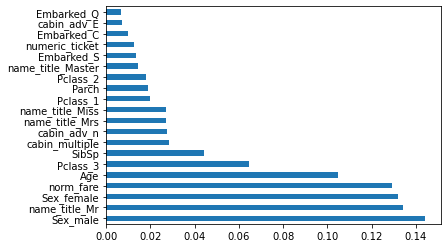

In [64]:
best_rf = best_clf_rf.best_estimator_.fit(X_train_scaled,y_train)
feat_importances = pd.Series(best_rf.feature_importances_, index=X_train_scaled.columns)
feat_importances.nlargest(20).plot(kind='barh')

In [65]:
xgb = XGBClassifier(random_state = 1)

param_grid = {
    'n_estimators': [450,500,550],
    'colsample_bytree': [0.75,0.8,0.85],
    'max_depth': [None],
    'reg_alpha': [1],
    'reg_lambda': [2, 5, 10],
    'subsample': [0.55, 0.6, .65],
    'learning_rate':[0.5],
    'gamma':[.5,1,2],
    'min_child_weight':[0.01],
    'sampling_method': ['uniform']
}

clf_xgb = GridSearchCV(xgb, param_grid = param_grid, cv = 5, verbose = True, n_jobs = -1)
best_clf_xgb = clf_xgb.fit(X_train_scaled,y_train)
clf_performance(best_clf_xgb,'XGB')

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


C:\Softwares\Anaconda\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:09:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGB
Best Score: 0.8549101758395226
Best Parameters: {'colsample_bytree': 0.85, 'gamma': 1, 'learning_rate': 0.5, 'max_depth': None, 'min_child_weight': 0.01, 'n_estimators': 500, 'reg_alpha': 1, 'reg_lambda': 10, 'sampling_method': 'uniform', 'subsample': 0.65}


In [66]:
y_hat_xgb = best_clf_xgb.best_estimator_.predict(X_test_scaled).astype(int)
xgb_submission = {'PassengerId': test.PassengerId, 'Survived': y_hat_xgb}
submission_xgb = pd.DataFrame(data=xgb_submission)
submission_xgb.to_csv('xgb_submission3.csv', index=False)

## 7. 集成其他方法建模

- 用三个估计器的硬投票分类器进行实验 (KNN, SVM, RF) (81.6%)
- 用三个估计器的软投票分类器进行实验 (KNN, SVM, RF) (82.3%) (Best Performance)
- 对除 xgb 之外的所有估计器进行软投票试验，其表现优于 80% (KNN, RF, LR, SVC) (82.9%)
- 对包括 XGB 在内的所有估算器进行软投票试验 (KNN, SVM, RF, LR, XGB) (83.5%)

In [67]:
best_lr = best_clf_lr.best_estimator_
best_knn = best_clf_knn.best_estimator_
best_svc = best_clf_svc.best_estimator_
best_rf = best_clf_rf.best_estimator_
best_xgb = best_clf_xgb.best_estimator_

voting_clf_hard = VotingClassifier(estimators = [('knn',best_knn),('rf',best_rf),('svc',best_svc)], voting = 'hard') 
voting_clf_soft = VotingClassifier(estimators = [('knn',best_knn),('rf',best_rf),('svc',best_svc)], voting = 'soft') 
voting_clf_all = VotingClassifier(estimators = [('knn',best_knn),('rf',best_rf),('svc',best_svc), ('lr', best_lr)], voting = 'soft') 
voting_clf_xgb = VotingClassifier(estimators = [('knn',best_knn),('rf',best_rf),('svc',best_svc), ('xgb', best_xgb),('lr', best_lr)], voting = 'soft')

print('voting_clf_hard :',cross_val_score(voting_clf_hard,X_train,y_train,cv=5))
print('voting_clf_hard mean :',cross_val_score(voting_clf_hard,X_train,y_train,cv=5).mean())

print('voting_clf_soft :',cross_val_score(voting_clf_soft,X_train,y_train,cv=5))
print('voting_clf_soft mean :',cross_val_score(voting_clf_soft,X_train,y_train,cv=5).mean())

print('voting_clf_all :',cross_val_score(voting_clf_all,X_train,y_train,cv=5))
print('voting_clf_all mean :',cross_val_score(voting_clf_all,X_train,y_train,cv=5).mean())

print('voting_clf_xgb :',cross_val_score(voting_clf_xgb,X_train,y_train,cv=5))
print('voting_clf_xgb mean :',cross_val_score(voting_clf_xgb,X_train,y_train,cv=5).mean())

voting_clf_hard : [0.79213483 0.81460674 0.82022472 0.79775281 0.83615819]
voting_clf_hard mean : 0.8121754586427983
voting_clf_soft : [0.78651685 0.82022472 0.81460674 0.79775281 0.85310734]
voting_clf_soft mean : 0.8144416936456548
voting_clf_all : [0.80898876 0.83146067 0.8258427  0.80898876 0.85875706]
voting_clf_all mean : 0.8268075922046595


C:\Softwares\Anaconda\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:10:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Softwares\Anaconda\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:10:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Softwares\Anaconda\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:10:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Softwares\Anaconda\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:10:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Softwares\Anaconda\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:10:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
voting_clf_xgb : [0.8258427  0.83146067 0.83707865 0.80337079 0.8700565 ]


C:\Softwares\Anaconda\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:10:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Softwares\Anaconda\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:10:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Softwares\Anaconda\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:10:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Softwares\Anaconda\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:10:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Softwares\Anaconda\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:10:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
voting_clf_xgb mean : 0.833561861232781


In [68]:
#in a soft voting classifier you can weight some models more than others. I used a grid search to explore different weightings
#no new results here
params = {'weights' : [[1,1,1],[1,2,1],[1,1,2],[2,1,1],[2,2,1],[1,2,2],[2,1,2]]}

vote_weight = GridSearchCV(voting_clf_soft, param_grid = params, cv = 5, verbose = True, n_jobs = -1)
best_clf_weight = vote_weight.fit(X_train_scaled,y_train)
clf_performance(best_clf_weight,'VC Weights')
voting_clf_sub = best_clf_weight.best_estimator_.predict(X_test_scaled)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
VC Weights
Best Score: 0.83244461372437
Best Parameters: {'weights': [1, 1, 1]}


In [69]:
#Make Predictions 
voting_clf_hard.fit(X_train_scaled, y_train)
voting_clf_soft.fit(X_train_scaled, y_train)
voting_clf_all.fit(X_train_scaled, y_train)
voting_clf_xgb.fit(X_train_scaled, y_train)

best_rf.fit(X_train_scaled, y_train)
y_hat_vc_hard = voting_clf_hard.predict(X_test_scaled).astype(int)
y_hat_rf = best_rf.predict(X_test_scaled).astype(int)
y_hat_vc_soft =  voting_clf_soft.predict(X_test_scaled).astype(int)
y_hat_vc_all = voting_clf_all.predict(X_test_scaled).astype(int)
y_hat_vc_xgb = voting_clf_xgb.predict(X_test_scaled).astype(int)

C:\Softwares\Anaconda\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:10:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [70]:
#convert output to dataframe 
final_data = {'PassengerId': test.PassengerId, 'Survived': y_hat_rf}
submission = pd.DataFrame(data=final_data)

final_data_2 = {'PassengerId': test.PassengerId, 'Survived': y_hat_vc_hard}
submission_2 = pd.DataFrame(data=final_data_2)

final_data_3 = {'PassengerId': test.PassengerId, 'Survived': y_hat_vc_soft}
submission_3 = pd.DataFrame(data=final_data_3)

final_data_4 = {'PassengerId': test.PassengerId, 'Survived': y_hat_vc_all}
submission_4 = pd.DataFrame(data=final_data_4)

final_data_5 = {'PassengerId': test.PassengerId, 'Survived': y_hat_vc_xgb}
submission_5 = pd.DataFrame(data=final_data_5)

final_data_comp = {'PassengerId': test.PassengerId, 'Survived_vc_hard': y_hat_vc_hard, 'Survived_rf': y_hat_rf, 'Survived_vc_soft' : y_hat_vc_soft, 'Survived_vc_all' : y_hat_vc_all,  'Survived_vc_xgb' : y_hat_vc_xgb}
comparison = pd.DataFrame(data=final_data_comp)

In [71]:
#track differences between outputs 
comparison['difference_rf_vc_hard'] = comparison.apply(lambda x: 1 if x.Survived_vc_hard != x.Survived_rf else 0, axis =1)
comparison['difference_soft_hard'] = comparison.apply(lambda x: 1 if x.Survived_vc_hard != x.Survived_vc_soft else 0, axis =1)
comparison['difference_hard_all'] = comparison.apply(lambda x: 1 if x.Survived_vc_all != x.Survived_vc_hard else 0, axis =1)

In [72]:
comparison.difference_hard_all.value_counts()

0    409
1      9
Name: difference_hard_all, dtype: int64